## Import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import f1_score

from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load in your data from kaggle.  
By working in a kaggle kernel, you can access the data directly from the competition, as well as make your submission without downloading your output file

In [ ]:
train = pd.read_csv('../input/climate-change-edsa2020-21/train.csv')
test = pd.read_csv('../input/climate-change-edsa2020-21/test.csv')

In [ ]:
train_copy = train
test_copy = test

In [ ]:
train_copy.sentiment.value_counts()

In [ ]:
#display value counts in a bar chart
train_copy['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

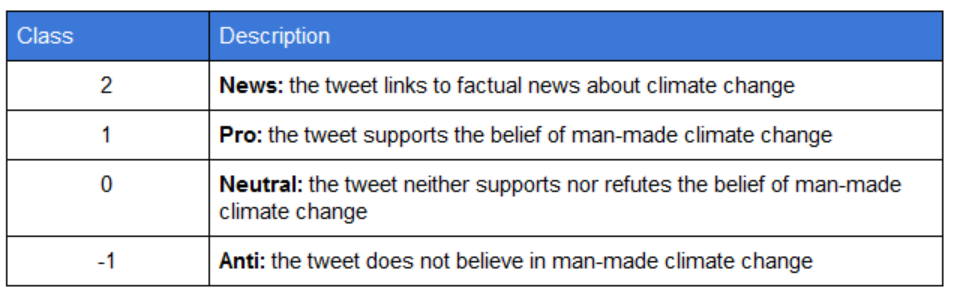

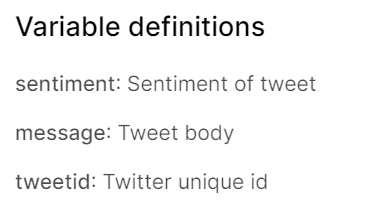

In [ ]:
#display first 5 entries of training data
train_copy.head()

In [ ]:
#display first 5 entries of test data
test_copy.head()

In [ ]:
train_copy.info()

# Text Cleaning

****REMOVING NOISE****[](http://)

In [ ]:
#removing the web-urls
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
train_copy['message'] = train_copy['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [ ]:
#remove punctuation and change to lower case
train_copy['message'] = train_copy['message'].str.lower()

print(string.punctuation)

def remove_punctuation(message):
    return ''.join([l for l in message if l not in string.punctuation])

train_copy['message'] = train_copy['message'].apply(remove_punctuation)

In [ ]:
#train_copy.head(50)

## Splitting out the X variable from the target

In [ ]:
y = train_copy['sentiment']
X = train_copy['message']

## Turning text into something your model can read

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
X_vectorized = vectorizer.fit_transform(X)

In [ ]:
#print(X_vectorized)

## Splitting the training data into a training and validation set

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_vectorized,y,test_size=.3,shuffle=True, stratify=y, random_state=24)

## Training the model and evaluating using the validation set 

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_val)

## Checking the performance of our model on the validation set

In [ ]:
f1_score(y_val, rfc_pred, average="macro")

## Getting our test set ready 

In [ ]:
testx = test['message']
test_vect = vectorizer.transform(testx)

## Making predictions on the test set and adding a sentiment column to our original test df

In [ ]:
y_pred = rfc.predict(test_vect)

In [ ]:
test['sentiment'] = y_pred

In [ ]:
test.head()

# Resampling

In [ ]:
# Separate classes
pro = train_copy[train_copy['sentiment']==1]
news = train_copy[train_copy['sentiment']==2]
neutral = train_copy[train_copy['sentiment']==0]
anti = train_copy[train_copy['sentiment']==-1]

sample_size = 8000

In [ ]:
# Downsample 1 : Pro
pro_downsampled = resample(pro,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=sample_size, # match number in minority class
                          random_state=24) # reproducible results

# Downsample 2 : News
#news_downsampled = resample(news,
#                          replace=False, # sample without replacement (no need to duplicate observations)
#                          n_samples=sample_size, # match number in minority class
#                          random_state=24) # reproducible results

# Upsample 2 : News
news_upsampled = resample(news,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=sample_size, # match number in minority class
                          random_state=24) # reproducible results


# Upsample 0 : Neutral
neutral_upsampled = resample(neutral,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=sample_size, # match number in minority class
                          random_state=24) # reproducible results

# Upsample -1 : Anti
anti_upsampled = resample(anti,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=sample_size, # match number in minority class
                          random_state=24) # reproducible results


# Combine downsampled majority class with minority class
resampled = pd.concat([pro_downsampled, news_upsampled, anti_upsampled, neutral_upsampled])

# Check new class counts
resampled['sentiment'].value_counts()

In [ ]:
resampled.info()

In [ ]:
resampled.head()

## Splitting out the X variable from the target

In [ ]:
y_resampled = resampled['sentiment']
X_resampled = resampled['message']

## Turning text into something your model can read

In [ ]:
vectorizer_resampled = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
X_resampled_vectorized = vectorizer_resampled.fit_transform(X_resampled)

In [ ]:
#print(X_resampled_vectorized)

## Splitting the training data into a training and validation set

In [ ]:
X_resampled_train,X_resampled_val,y_resampled_train,y_resampled_val = train_test_split(X_resampled_vectorized,y_resampled,test_size=.3,shuffle=True, stratify=y_resampled, random_state=24)

## Training the model and evaluating using the validation set 

In [ ]:
rfc_resampled = RandomForestClassifier()
rfc_resampled.fit(X_resampled_train, y_resampled_train)
rfc_resampled_pred = rfc_resampled.predict(X_resampled_val)

## Checking the performance of our model on the validation set

In [ ]:
f1_score(y_resampled_val, rfc_resampled_pred, average="macro")

## Getting our test set ready 

In [ ]:
testx_resampled = test_copy['message']
test_vect_resampled = vectorizer_resampled.transform(testx_resampled)

## Making predictions on the test set and adding a sentiment column to our original test df

In [ ]:
y_resampled_pred = rfc_resampled.predict(test_vect_resampled)

In [ ]:
test_copy['sentiment'] = y_resampled_pred

In [ ]:
test_copy.head()

# Creating an output csv for submission

In [ ]:
test_copy[['tweetid','sentiment']].to_csv('testsubmission.csv', index=False)